# Molecular Data Analysis 

In this notebook, I focus on classifying epithelial cells in the spatial Xenium dataset. The main questions are:

- Are there significant differences between gene signatures of ductal (IDC) and lobular (ILC) carcinoma derived from scRNA-seq data?
- Are scRNA-seq-derived signatures effective at distinguishing epithelial cells in Xenium?
- Which type of signature, subtype-specific or general, provides the most accurate classification? 

## 1. Library Imports

In this step, I load the libraries required for data preprocessing and analysis.

In [16]:
import scanpy as sc
import spatialdata as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import contextlib
import logging
import os
import mygene
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn3
from matplotlib.patches import Patch

## 2. Dataset Loading

I load the three main datasets:

- **Xenium_V1_FFPE_Human_Breast_IDC.zarr**: obtained from the 10x Genomics Xenium platform. This dataset represents a tissue section of invasive ductal breast carcinoma (IDC), formalin-fixed and paraffin-embedded (FFPE), and includes a total of 574,852 cells and 280 genes. In this notebook, I refer to it as *xenium*.
- **cbbb607f-578b-47ba-858b-407bb8be917f.h5ad**: contains 100,064 cells and 29,067 genes. It is a single-cell and spatially resolved atlas of human breast cancers, referred to as *adata_small*.
- **breast_cancer_atlas_cellxgene_epithelial.h5ad**: contains 1,101,803 cells and 61,888 genes, referred to as *adata_big*.

The last two datasets (*adata_small* and *adata_big*) are available on the CellxGene platform (https://cellxgene.cziscience.com/collections).
- **classification_df**: dataFrame containing the initial classification of cell types for the Xenium dataset.

The datasets contain multiple cell populations and will be filtered to retain only epithelial cells.

In [17]:
adata_small = sc.read('/mnt/ptemp/virginia/project/cbbb607f-578b-47ba-858b-407bb8be917f.h5ad')
adata_big = sc.read_h5ad("/mnt/ptemp/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")
classification_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

## 3. Epithelial Cell Selection

In [18]:
adata_small.X = adata_small.raw.X 
adata_small.X.data

# Filter `adata_small` to retain only epithelial cells
adata_small_epit = adata_small[
    (adata_small.obs['celltype_major'].isin(['Normal Epithelial', 'Cancer Epithelial']))].copy()

# Rename cell types in `adata_small_epit`: "Cancer Epithelial" → "Malignant_epithelial" and "Normal Epithelial" → "Normal_epithelial"
adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(
    {"Cancer Epithelial": "Malignant_epithelial", "Normal Epithelial": "Normal_epithelial"})

# Retrieve the associated table
xenium_table = list(xenium.tables.values())[0]
xenium_gene_ids = xenium_table.var['gene_ids'].tolist()
adata_gene_ids = adata_big.var['feature_id'].tolist()  

# Compare the gene IDs
only_in_xenium = set(xenium_gene_ids) - set(adata_gene_ids)
only_in_adata = set(adata_gene_ids) - set(xenium_gene_ids)
print(f"Genes only in xenium: {len(only_in_xenium)}")  
print(f"Genes only in adata_big: {len(only_in_adata)}")

# Filter `adata_big` to keep only genes present in `xenium`
adata_big_filtered = adata_big[:, adata_big.var['feature_id'].isin(xenium_gene_ids)]
print(f"After filtering, the shape of adata_big_filtered is: {adata_big_filtered.shape}")  

adata_big_filtered = adata_big_filtered.copy()
adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()
adata_big_filtered.var = adata_big_filtered.var[['feature_id'] + 
                                                [col for col in adata_big_filtered.var.columns if col != 'feature_id']]
adata_big_filtered.var.set_index("feature_id", inplace=True)

# Create a combined AnnData object by merging `adata_small` and `adata_big`, keeping the cell type labels `Normal_epithelial` and `Malignant_epithelial`
adata_combined = ad.concat([adata_small_epit, adata_big_filtered], join="outer")

adata_xenium = xenium.tables['table']
adata_xenium_cell_ids = set(adata_xenium.obs['cell_id'])
filtered_classification_df = classification_df[classification_df['cell_id'].isin(adata_xenium_cell_ids)]

# Add the 'level1' column from `classification_df` to `adata_original.obs` based on 'cell_id'
adata_xenium.obs['level1'] = adata_xenium.obs['cell_id'].map(filtered_classification_df.set_index('cell_id')['level1'])
adata_xenium.obs['level2'] = adata_xenium.obs['cell_id'].map(filtered_classification_df.set_index('cell_id')['level2'])

adata_xenium.obs['level2'] = adata_xenium.obs['level2'].replace({
    'Malignant_epithelial': 'Malignant',
    'Normal_epithelial': 'Normal'})

# Filter the AnnData to include only cells with 'Epithelial' in the 'level1' column
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial'].copy()
print(f"Number of epithelial cells: {epithelial_cells.shape[0]}")  

# Save the filtered dataset
epithelial_cells = epithelial_cells.copy()
epithelial_cells.write("epithelial_cells_level2.h5ad")

Genes only in xenium: 0
Genes only in adata_big: 61608
After filtering, the shape of adata_big_filtered is: (1101803, 280)
Number of epithelial cells: 350729


## 4. Evaluation of Gene Signature to Use

- Invasive Ductal Carcinoma (**IDC**): the most common form of breast cancer, originating from the milk ducts.  
- Invasive Lobular Carcinoma (**ILC**): the second most common form, arising from the breast lobules.

In [19]:
epithelial_cells.var_names = epithelial_cells.var['gene_ids']
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells)

In [20]:
# IDC (NORMAL + TUMOR) 

adata_filtered_IDC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) 
].copy()

adata_filtered_IDC

AnnData object with n_obs × n_vars = 22196 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [21]:
# IDC (NORMAL + TUMOR) + ILC (NORMAL + TUMOR)

adata_filtered_IDC_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    )
].copy()

adata_filtered_IDC_ILC

AnnData object with n_obs × n_vars = 26619 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [22]:
# IDC (NORMAL + TUMOR) + ILC (NORMAL)

adata_filtered_IDC_normal_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'] == 'Normal_epithelial')
    )
].copy()

adata_filtered_IDC_normal_ILC

AnnData object with n_obs × n_vars = 24184 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [23]:
# List of Datasets to Analyze
datasets = {
    "IDC(N+T)": adata_filtered_IDC,
    "IDC(N+T) + ILC(N)": adata_filtered_IDC_normal_ILC,
    "IDC(N+T) + ILC(N+T)": adata_filtered_IDC_ILC}

# Loop through all datasets
for name, adata in datasets.items():
    n_malignant = adata.obs[adata.obs['celltype_major'] == 'Malignant_epithelial'].shape[0]
    n_normal = adata.obs[adata.obs['celltype_major'] == 'Normal_epithelial'].shape[0]
    
    print(f"Dataset: {name}")
    print(f"  Malignant epithelial cells: {n_malignant}")
    print(f"  Normal epithelial cells: {n_normal}\n")

Dataset: IDC(N+T)
  Malignant epithelial cells: 19829
  Normal epithelial cells: 2367

Dataset: IDC(N+T) + ILC(N)
  Malignant epithelial cells: 19829
  Normal epithelial cells: 4355

Dataset: IDC(N+T) + ILC(N+T)
  Malignant epithelial cells: 22264
  Normal epithelial cells: 4355



In [24]:
def compute_scores(datasets, epithelial_cells, group="celltype_major", variable="logfoldchanges", n_genes=50):
    """
    Performs DGE, saves top malignant and normal genes, and computes scores on epithelial cells.    
    Returns a dictionary with the selected top malignant and normal genes for each dataset.
    """
    signature_dict = {}
    
    for name, adata in datasets.items():
        print(f"\nProcessing dataset: {name}")
        
        # Normalize and log-transform
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        
        # Keep only genes present in epithelial_cells
        adata_filtered = adata[:, adata.var_names.isin(epithelial_cells.var_names)].copy()
        print(f"Number of genes after filtering: {len(adata_filtered.var_names)}")
        
        # Differential gene expression (DGE)
        sc.tl.rank_genes_groups(adata_filtered, groupby=group, method="wilcoxon")
        
        # Dotplot
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            sc.pl.rank_genes_groups_dotplot(
                adata_filtered,
                groupby=group,
                standard_scale="var",
                n_genes=10,
                title=f"Marker Genes {name}",
                show=False,
                save=f"Marker_Genes_{name}.pdf")

        # Save malignant genes
        cancer_genes = sc.get.rank_genes_groups_df(adata_filtered, group="Malignant_epithelial")
        os.makedirs("results", exist_ok=True)
        cancer_genes.to_csv(f'results/cancer_genes_Malignant_epithelial_{name}.csv', index=False)
        
        # Select significant genes
        df_epit_selected_cancer = cancer_genes[(cancer_genes[variable] > 0.58) & (cancer_genes['pvals'] <= 0.01)]
        df_epit_selected_cancer = df_epit_selected_cancer.sort_values(by=variable, ascending=False).head(n_genes)['names'].tolist()

        df_epit_selected_normal = cancer_genes[(cancer_genes[variable] < -0.58) & (cancer_genes['pvals'] <= 0.01)]
        df_epit_selected_normal = df_epit_selected_normal.sort_values(by=variable, ascending=True).head(n_genes)['names'].tolist()

        # Compute gene scores on epithelial cells
        sc.tl.score_genes(epithelial_cells, df_epit_selected_cancer, ctrl_as_ref=True, score_name=f'{name}_malignant_signature')
        sc.tl.score_genes(epithelial_cells, df_epit_selected_normal, ctrl_as_ref=True, score_name=f'{name}_normal_signature')
        
        # Store in dictionary
        signature_dict[name] = {
            "malignant": df_epit_selected_cancer,
            "normal": df_epit_selected_normal}
        
        print(f"Saved scores for {name}: {len(df_epit_selected_cancer)} malignant genes, {len(df_epit_selected_normal)} normal genes")
            
    return signature_dict


def clean_epithelial_cells(epithelial_cells):
    """ Removes unnecessary columns and renames the normal_signature """
    cols_to_drop = [c for c in epithelial_cells.obs.columns if c in ['IDC_malignant_signature', 'IDC_ILC_malignant_signature']]
    epithelial_cells.obs.drop(columns=cols_to_drop, inplace=True)
    
    # Rename normal column
    if 'IDC-and_Normal_ILC_malignant_signature' in epithelial_cells.obs.columns:
        epithelial_cells.obs.rename(columns={'IDC-and_Normal_ILC_malignant_signature': 'malignant_signature'}, inplace=True)


def convert_ensembl_to_symbol(signature_dict):
    """ Converts a list of Ensembl IDs to gene symbols using MyGeneInfo. """
    mg = mygene.MyGeneInfo()
    converted_dfs = {}
    
    for name, genes_dict in signature_dict.items():
        converted_dfs[name] = {}
        for key, gene_list in genes_dict.items():
            cleaned_ids = [g.split('.')[0] for g in gene_list]

            # Silence MyGene output
            with contextlib.redirect_stdout(open(os.devnull, "w")), \
                 contextlib.redirect_stderr(open(os.devnull, "w")):
                results = mg.querymany(
                    cleaned_ids,
                    scopes='ensembl.gene',
                    fields='symbol',
                    species='human')
            
            id_to_symbol = {r['query']: r.get('symbol', 'NA') for r in results}
            gene_symbols = [id_to_symbol.get(g.split('.')[0], 'NA') for g in gene_list]
            
            df = pd.DataFrame({
                "ensembl_id": gene_list,
                "gene_symbol": gene_symbols})
            converted_dfs[name][key] = df
        
    return converted_dfs


def plot_malignant_heatmap(converted_dfs, output_file="figures/malignant_gene_symbol_heatmap.pdf"):
    """ Creates a binary heatmap of malignant genes present across different datasets. """
    gene_sets_symbol = {
        name: set(df['malignant']['gene_symbol']) - {"NA", ""}  # remove missing symbols
        for name, df in converted_dfs.items()
        if 'malignant' in df}

    all_genes = sorted(set().union(*gene_sets_symbol.values()))

    data = {
        group: [1 if gene in gene_sets_symbol[group] else 0 for gene in all_genes]
        for group in gene_sets_symbol}

    df_binary = pd.DataFrame(data, index=all_genes)

    bw_cmap = ListedColormap(["white", "black"])
    plt.figure(figsize=(6, len(df_binary) * 0.25))
    sns.heatmap(
        df_binary,
        cmap=bw_cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='grey')

    plt.title("Malignant gene presence across IDC/ILC signatures", fontsize=14)
    plt.xlabel("Signature", fontsize=12)
    plt.ylabel("Gene Symbol", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_malignant_venn(converted_dfs, output_file="figures/malignant_venn_signatures.pdf"):
    """Create a Venn diagram of shared malignant genes across three datasets."""
    sets = []
    labels = []
    
    for name, df_dict in converted_dfs.items():
        if 'malignant' in df_dict:
            sets.append(set(df_dict['malignant']['gene_symbol']) - {"NA", ""})
            labels.append(name)
    
    if len(sets) != 3:
        print("Venn plot requires exactly 3 sets.")
        return
    
    plt.figure()
    venn3(sets, set_labels=tuple(labels))
    plt.title("Malignant gene overlap between signatures")
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


Processing dataset: IDC(N+T)
Number of genes after filtering: 280
Saved scores for IDC(N+T): 43 malignant genes, 48 normal genes

Processing dataset: IDC(N+T) + ILC(N)
Number of genes after filtering: 280
Saved scores for IDC(N+T) + ILC(N): 45 malignant genes, 50 normal genes

Processing dataset: IDC(N+T) + ILC(N+T)
Number of genes after filtering: 280
Saved scores for IDC(N+T) + ILC(N+T): 43 malignant genes, 50 normal genes


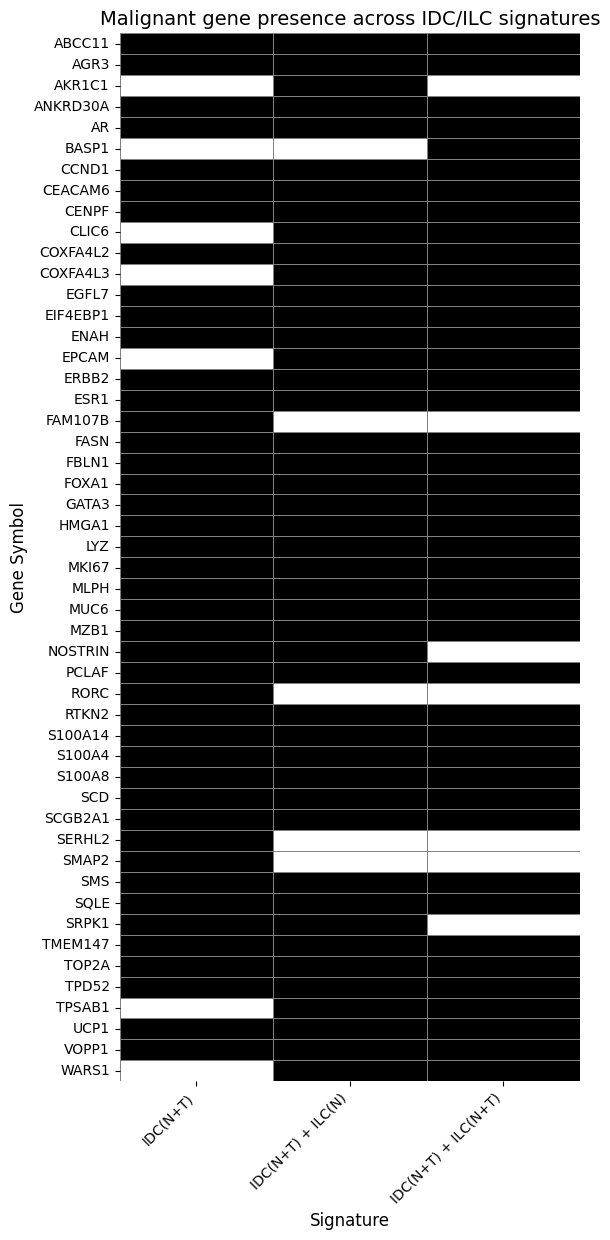

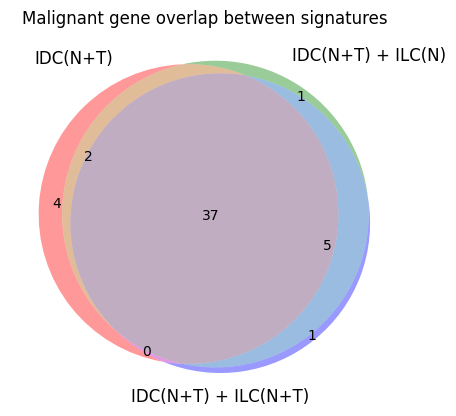

In [25]:
logging.getLogger("mygene").setLevel(logging.ERROR)

#prepare_directories()

# Differential Gene Expression (DGE) and scoring
signature_dict = compute_scores(
    datasets={
        "IDC(N+T)": adata_filtered_IDC,
        "IDC(N+T) + ILC(N)": adata_filtered_IDC_normal_ILC,
        "IDC(N+T) + ILC(N+T)": adata_filtered_IDC_ILC},
    epithelial_cells=epithelial_cells)

# Ensembl to Gene Symbol conversion
converted_dfs = convert_ensembl_to_symbol(signature_dict)

# Binary heatmap
plot_malignant_heatmap(converted_dfs)

# Venn plot
plot_malignant_venn(converted_dfs)

The **subtype-specific signature IDC (NORMAL + TUMOR) + ILC (NORMAL)** is the most effective for classifying epithelial cells for the following reasons:
- The Density Plot shows a clear separation between normal and malignant cells.
- It includes a higher number of normal cells (4,355 cells).
- Malignant cells are specific to IDC, totaling 19,829 cells.

## 5. Application of ATLAS Signatures to Xenium

In [26]:
# Remove unnecessary columns (keep only those for the IDC(N+T) + ILC(N) dataset)
cols_to_drop = ["IDC(N+T)_malignant_signature", "IDC(N+T)_normal_signature", "IDC(N+T) + ILC(N+T)_malignant_signature", "IDC(N+T) + ILC(N+T)_normal_signature"]
epithelial_cells.obs.drop(columns=[c for c in cols_to_drop if c in epithelial_cells.obs.columns], inplace=True)

# Rename the column for simplicity
if "IDC(N+T) + ILC(N)_malignant_signature" in epithelial_cells.obs.columns:
    epithelial_cells.obs.rename(columns={"IDC(N+T) + ILC(N)_malignant_signature": "malignant_signature"}, inplace=True)
if "IDC(N+T) + ILC(N)_normal_signature" in epithelial_cells.obs.columns:
    epithelial_cells.obs.rename(columns={"IDC(N+T) + ILC(N)_normal_signature": "normal_signature"}, inplace=True)

In [27]:
# QUALITY FILTERING

# Filter all cells with total_counts > 10
epi_filtered = epithelial_cells[epithelial_cells.obs["total_counts"] > 10].copy()
print(f"Total epithelial cells with total_counts > 10: {epi_filtered.shape[0]}")

epi_filtered.write("epi_filtered.h5ad")

Total epithelial cells with total_counts > 10: 348692


Cell type counts:
 cell_type_prediction
Malignant    319136
Normal        25245
Unknown        4311
Name: count, dtype: int64


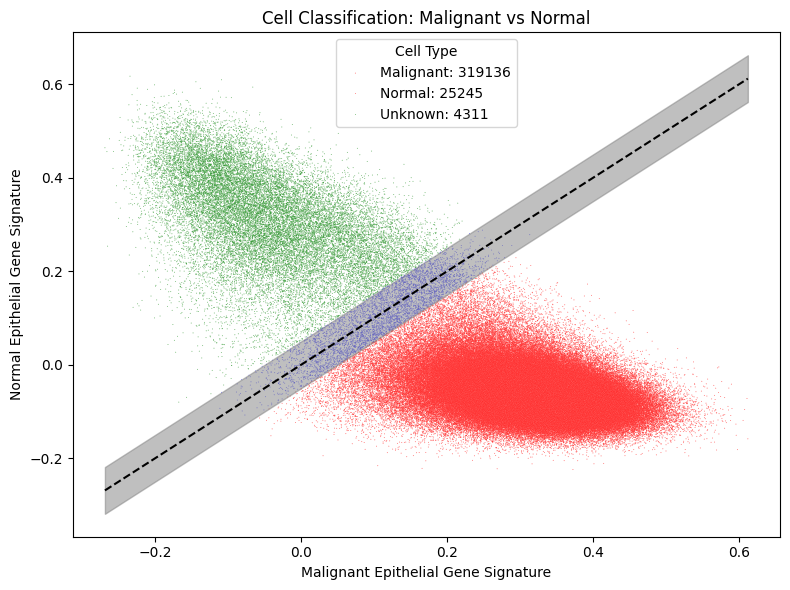

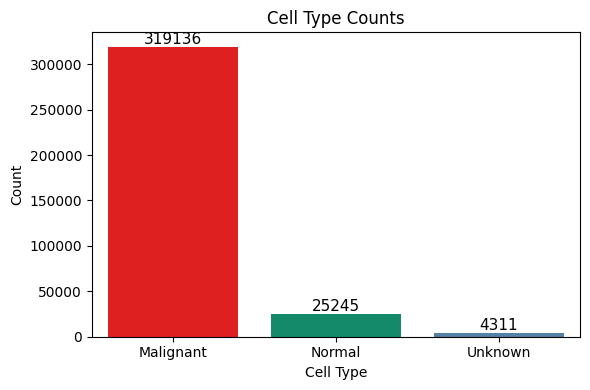

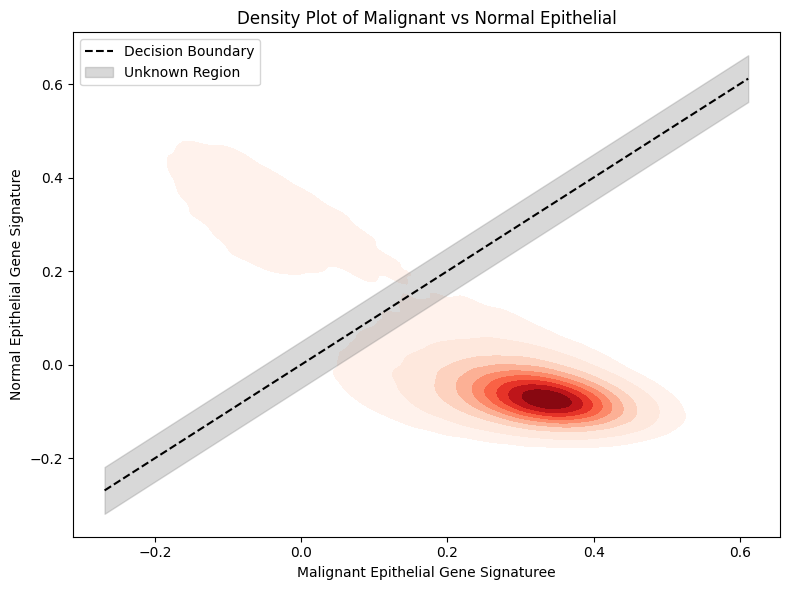

In [28]:
x = epi_filtered.obs['malignant_signature']
y = epi_filtered.obs['normal_signature']

# Parameter: width of the "unknown" band
boundary_width = 0.05

diff = y - x

def classify(diff_value, threshold):
    if diff_value > threshold:
        return 'Normal'
    elif diff_value < -threshold:
        return 'Malignant'
    else:
        return 'Unknown'

epi_filtered.obs['cell_type_prediction'] = diff.apply(lambda d: classify(d, threshold=boundary_width))

# Count cells per category
cell_counts = epi_filtered.obs['cell_type_prediction'].value_counts()
print("Cell type counts:\n", cell_counts)

# --- SCATTERPLOT WITH DIAGONAL AND "UNKNOWN" BOUNDARY ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=x,
    y=y,
    hue=epi_filtered.obs['cell_type_prediction'],
    hue_order=['Malignant', 'Normal', 'Unknown'], 
    palette={'Malignant': 'red', 'Normal': 'green', 'Unknown': 'blue'},
    alpha=0.6,
    s=0.5)

plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
x_vals = np.linspace(x.min(), x.max(), 500)
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.5, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signature')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Cell Classification: Malignant vs Normal')
plt.legend(title="Cell Type", labels=[
    f"Malignant: {cell_counts.get('Malignant', 0)}", 
    f"Normal: {cell_counts.get('Normal', 0)}", 
    f"Unknown: {cell_counts.get('Unknown', 0)}"])
plt.tight_layout()
plt.savefig("figures/scatter_malignant_vs_normal_epi_filtered.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- BARPLOT WITH CELL COUNT ---
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', '#009E73', '#4682B4'])
plt.title('Cell Type Counts')
plt.xlabel('Cell Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig("figures/barplot_cell_counts_epi_filtered.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- DENSITY PLOT ---
plt.figure(figsize=(8, 6))
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.3, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signaturee')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.legend()
plt.tight_layout()
plt.savefig("figures/density_malignant_vs_normal_epi_filtered.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [14]:
# Load the initial AnnData containing only epithelial cells with level1 and level2 classification
epithelial_cells_old = sc.read_h5ad("epithelial_cells_level2.h5ad")

# Replace var
epi_filtered.var = epithelial_cells_old.var.copy()
# If you want to be sure that the index (var_names) is also the same:
epi_filtered.var_names = epithelial_cells_old.var_names.copy()

# Add the cell_type_prediction column to the initial file
epithelial_cells_old.obs['malignant_signature'] = epi_filtered.obs['malignant_signature']
epithelial_cells_old.obs['normal_signature'] = epi_filtered.obs['normal_signature']
epithelial_cells_old.obs['cell_type_prediction'] = epi_filtered.obs['cell_type_prediction']

# Save the file
epi_filtered.write("epithelial_cells_cell_type_prediction_filtered.h5ad")

### Spatial Visualization of Cell Type Predictions

This code block processes and visualizes the spatial distribution of cell types in a breast cancer tissue sample analyzed with Xenium.

- It starts by copying the metadata table and extracting spatial coordinates (`x`, `y`) for each cell.
- Each predicted cell type category (`Malignant`, `Normal`, and `Unknown`) is assigned a distinct color for visualization.
- A scatter plot is generated to show the spatial locations of cells, colored by their predicted type.

This visualization helps assess whether malignant and normal cells are spatially segregated or intermixed within the tissue section.

In [15]:
# Standardize the data types of the cell_id columns ---
epi_filtered.obs['cell_id'] = epi_filtered.obs.index.astype(str)
xenium.tables['table'].obs['cell_id'] = xenium.tables['table'].obs['cell_id'].astype(str)

# Merge the data using only epithelial cells ---
merged_obs = pd.merge(
    xenium.tables['table'].obs, 
    epi_filtered.obs[['cell_type_prediction', 'cell_id']], 
    on="cell_id",  
    how="left")
xenium.tables['table'].obs = merged_obs

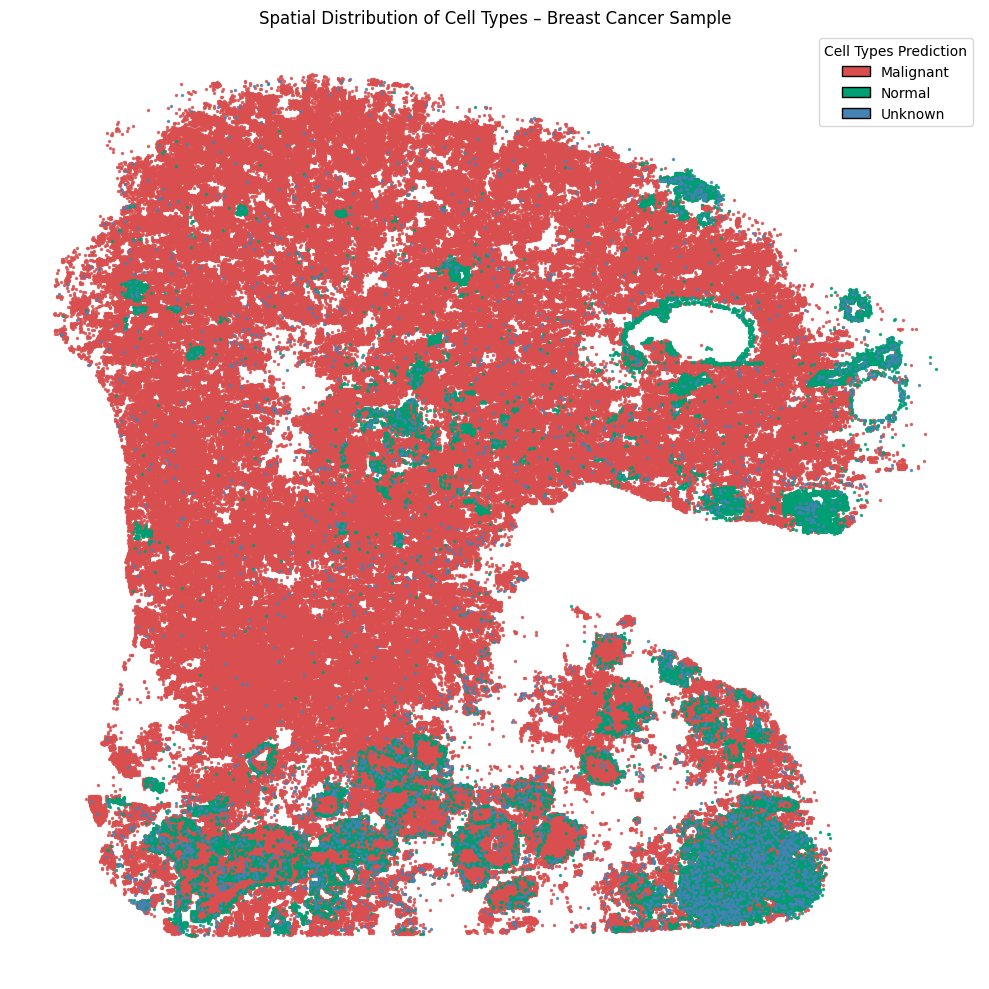

cell_type_prediction
Malignant    319136
Normal        25245
Unknown        4311
Name: count, dtype: int64


In [17]:
# Copy data into a DataFrame 
cell_geometries = xenium.tables['table'].obs.copy()

# Add spatial coordinates 
coords = pd.DataFrame(xenium.tables['table'].obsm['spatial'], index=cell_geometries.index, columns=['x','y'])
cell_geometries = cell_geometries.join(coords)

# Group subtypes into three main categories 
def map_celltype(celltype):
    if celltype is None or pd.isna(celltype):
        return 'Unknown'
    celltype_lower = str(celltype).lower()
    if 'malignant' in celltype_lower:
        return 'Malignant'
    elif 'normal' in celltype_lower:
        return 'Normal'
    else:
        return 'Unknown'

cell_geometries['cell_type_group'] = cell_geometries['cell_type_prediction'].apply(map_celltype)

# Define colors 
color_dict = {
    'Malignant': '#D94F4F',  
    'Normal': '#009E73',     
    'Unknown': '#4682B4'}

# Visualization 
fig, ax = plt.subplots(figsize=(10,10))
for celltype, color in color_dict.items():
    subset = cell_geometries[cell_geometries['cell_type_group'] == celltype]
    subset.plot.scatter(x='x', y='y', ax=ax, color=color, s=2, alpha=0.8)

# Legend
legend_elements = [Patch(facecolor=color, edgecolor='k', label=celltype) for celltype, color in color_dict.items()]
ax.legend(handles=legend_elements, title="Cell Types Prediction", loc="upper right")

plt.title("Spatial Distribution of Cell Types – Breast Cancer Sample")
plt.axis("off")
ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout()
plt.savefig("figures/spatial_distribution_of_cell_type.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Check values
print(xenium.tables['table'].obs['cell_type_prediction'].value_counts())